In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import json
import copy
import os
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.utils.data
torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if os.path.isdir('vision')==False:
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.8.2
    !cp references/detection/utils.py ../
    !cp references/detection/transforms.py ../
    !cp references/detection/coco_eval.py ../
    !cp references/detection/engine.py ../
    !cp references/detection/coco_utils.py ../
    %cd ../
    cwd = os.getcwd()
    print(cwd)

Cloning into 'vision'...
remote: Enumerating objects: 255733, done.
remote: Counting objects: 100% (8412/8412), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 255733 (delta 7929), reused 8318 (delta 7885), pack-reused 247321
Receiving objects: 100% (255733/255733), 515.31 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (232851/232851), done.
/content/vision
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)
/content
/content


In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# This cell was used to extract masks

In [5]:

# source_folder = os.path.join(os.getcwd(), "/content/drive/MyDrive/data/images/train")
# json_path = "/content/drive/MyDrive/data/json_Files/train/via_project_21Nov2022_14h17m_coco.json"                     
# count = 0                                           # Count of total images saved
# file_bbs = {}                                       # Dictionary containing polygon coordinates for mask
									
# # Read JSON file
# with open(json_path) as f:
#   data = json.load(f)

# # Extract X and Y coordinates if available and update dictionary
# def add_to_dict(data, i, key):
#   d = data["annotations"][i]["segmentation"][0]
#   n = len(d)
#   all_points = []
#   for idx in range(0,n,2):
#       all_points.append( [d[idx], d[idx+1]] )

#   lst = [data["images"][i]["width"],data["images"][i]["height"]]
#   file_bbs[key] = (all_points, lst)

# for i, itr in enumerate(data["images"]):
#     file_name_json = itr["file_name"]
#     add_to_dict(data, i, file_name_json[:-4])

			
# print("\nDict size: ", len(file_bbs))

# for file_name in os.listdir(source_folder):
#     to_save_folder = os.path.join(source_folder, file_name[:-4])
#     image_folder = os.path.join(to_save_folder, "images")
#     mask_folder = os.path.join(to_save_folder, "masks")
#     curr_img = os.path.join(source_folder, file_name)
    
#     # make folders and copy image to new location
#     os.mkdir(to_save_folder)
#     os.mkdir(image_folder)
#     os.mkdir(mask_folder)
#     os.rename(curr_img, os.path.join(image_folder, file_name))
        
# # For each entry in dictionary, generate mask and save in correponding 
# # folder
# for itr in file_bbs:
#     num_masks = itr.split("*")
#     to_save_folder = os.path.join(source_folder, num_masks[0])
#     mask_folder = os.path.join(to_save_folder, "masks")
    
#     mask = np.zeros((file_bbs[itr][1][1], file_bbs[itr][1][0]))
#     try:
#         arr = np.array(file_bbs[itr][0])
#     except:
#         print("Not found:", itr)
#         continue
#     count += 1
#     cv2.fillPoly(mask, [arr], color=(255))

#     cv2.imwrite(os.path.join(mask_folder, itr + ".png") , mask)
        
# print("Images saved:", count)

(-0.5, 6239.5, 4159.5, -0.5)

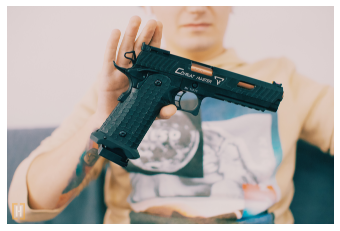

In [6]:
im = Image.open("/content/drive/MyDrive/dataToDrive/images/aleksey-kashmar-rxoKm1qeJ78-unsplash.jpg")
plt.imshow(im)
plt.axis('off')

(-0.5, 6239.5, 4159.5, -0.5)

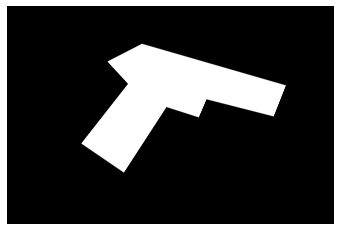

In [7]:
mask = Image.open("/content/drive/MyDrive/dataToDrive/masks/aleksey-kashmar-rxoKm1qeJ78-unsplash.png").convert("L")
mask.putpalette([
    0, 0, 0, 
    255, 0, 0, 
])
plt.imshow(mask)
plt.axis('off')

In [8]:
class GunDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
dataset = GunDataset("/content/drive/MyDrive/dataToDrive/")
dataset[0]

(<PIL.Image.Image image mode=RGB size=6240x4160 at 0x7FB28A42C990>,
 {'boxes': tensor([[1417.,  721., 5322., 3179.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([9598490.]),
  'iscrowd': tensor([0])})

# Transforming and augmenting images


In [10]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
      transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
dataset = GunDataset("/content/drive/MyDrive/dataToDrive/", get_transform(train=True))
dataset_test = GunDataset("/content/drive/MyDrive/dataToDrive/", get_transform(train=False))

In [12]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

In [13]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer, num_classes)
    return model

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

# our dataset has two classes only - background and gun
num_classes = 2

model = build_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)  

device: cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [15]:
# number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:05:25  lr: 0.000268  loss: 1.8831 (1.8831)  loss_classifier: 0.4346 (0.4346)  loss_box_reg: 0.1235 (0.1235)  loss_mask: 1.3209 (1.3209)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 16.2505  data: 8.1388  max mem: 2836
Epoch: [0]  [ 5/20]  eta: 0:00:53  lr: 0.001582  loss: 1.8831 (2.1753)  loss_classifier: 0.3072 (0.3027)  loss_box_reg: 0.1193 (0.1105)  loss_mask: 1.3209 (1.7343)  loss_objectness: 0.0023 (0.0220)  loss_rpn_box_reg: 0.0034 (0.0058)  time: 3.5565  data: 2.0088  max mem: 3324
Epoch: [0]  [10/20]  eta: 0:00:35  lr: 0.002897  loss: 1.5688 (1.6797)  loss_classifier: 0.1538 (0.2043)  loss_box_reg: 0.0968 (0.0964)  loss_mask: 1.2766 (1.3329)  loss_objectness: 0.0236 (0.0365)  loss_rpn_box_reg: 0.0072 (0.0097)  time: 3.5880  data: 2.6202  max mem: 3714
Epoch: [0]  [15/20]  eta: 0:00:15  lr: 0.004211  loss: 1.1882 (1.4380)  loss_classifier: 0.1186 (0.1730)  loss_box_reg: 0.0859 (0.0924)  loss_mask: 0.9463 (1.1328)  loss_o

In [16]:
# pick one image from the test set
img, _ = dataset_test[6]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

(-0.5, 4271.5, 2847.5, -0.5)

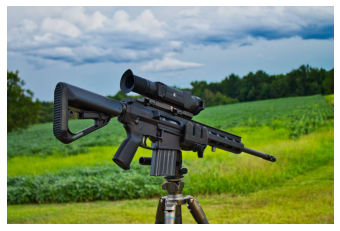

In [17]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.imshow(im)
plt.axis('off')

(-0.5, 4271.5, 2847.5, -0.5)

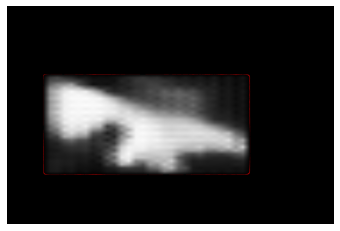

In [18]:
im = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
im.putpalette([
    0, 0, 0,
    255, 0, 0
])
plt.imshow(im)
plt.axis('off')

In [19]:
CLASS_NAMES = ['__background__', 'Gun']

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    confidence = max(pred_score)
    print(f"The confidence is: {confidence}")
    pred_t = [pred_score.index(x) for x in pred_score if x==confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=5, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
      #cv2.rectangle and cv2.putText version dependent
      pt1 = tuple([int(j) for j in boxes[i][0]])
      pt2 = tuple([int(j) for j in boxes[i][1]])  
      cv2.rectangle(img, pt1, pt2,color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

The confidence is: 0.4278615117073059


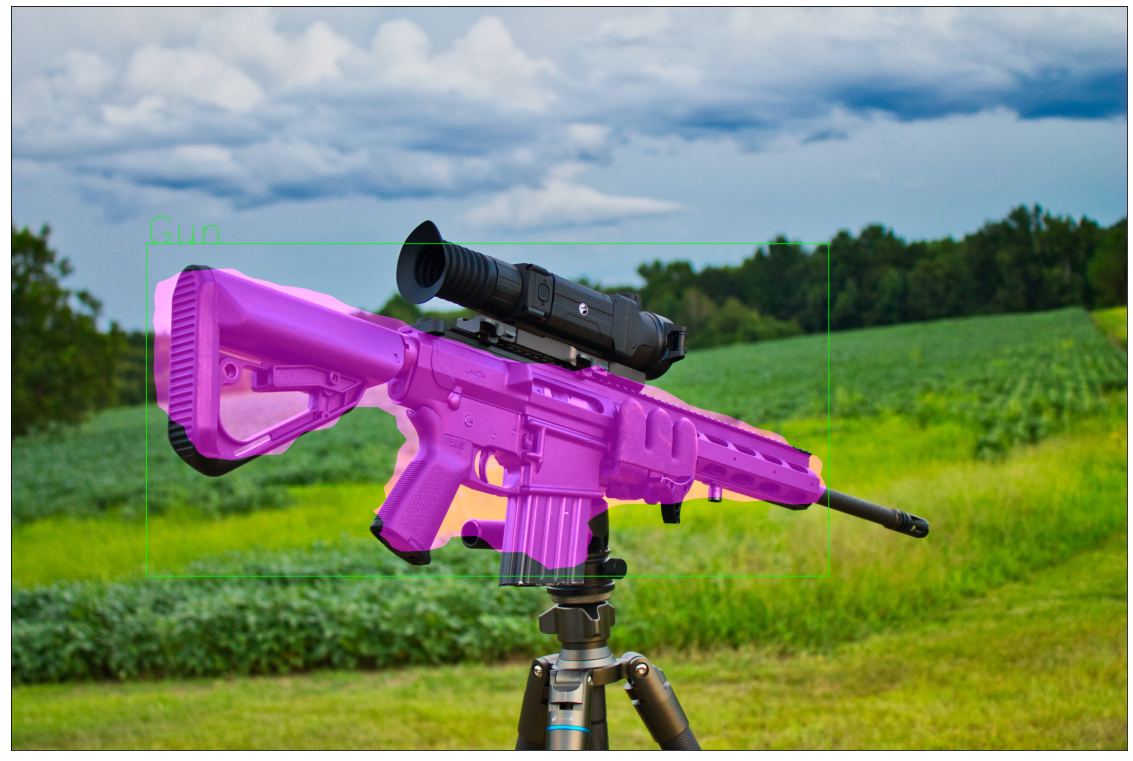

In [21]:
segment_instance('/content/drive/MyDrive/dataToDrive/images/clint-patterson-pfAJdLPqisg-unsplash.jpg')

In the last figure, I did not specify the confidence, I printed the box which has the maximum confidence. The quality of the images is quite high so the data need more capacity to train and get a good result. I used Resnet architecture. A bigger and deeper architecture might be more accurate.